In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from imblearn.metrics import sensitivity_specificity_support
from IPython.core.display import display, HTML
from sklearn import preprocessing

<h2>Função de Especificidade e Sensibilidade</h2>
<h10><hr></h10>
<h4>Sendo a sensitividade relacionada a proporção de verdadeiros positivos (capacidade do sistema de reconhecer dados positivos (no caso: sobreviventes)) - (VP)/(VP + FN)</h4>
<h4>e a especificidade é relacionada a proporção de verdadeiros negativos (capacidade do sistema de reconhecer dados falsos (no caso: mortos)) - (VN)/(VN + FP)</h4>

In [73]:
def Sensitivity_specificity(confusion_matrix, model_name):
    print('Sensitividade do modelo {0}: {1:.3f}' .format(model_name, (conf[1][1])/(conf[1][0] + conf[1][1])))
    print('Especificidade do modelo {0}: {1:.3f}' .format(model_name, conf[0][0]/(conf[0][0] + conf[0][1])))
    return ''

<h2>Abrindo e armazenando o arquivo csv com o pandas</h2>

In [60]:
titanic_file = 'train.csv'
titanic_data = pd.read_csv(titanic_file)

<h2>Retirando linhas contendo atributos em branco relativos a coluna de idade</h2>

In [61]:
print("Total de linhas retiradas: {}".format(titanic_data['Age'].isnull().sum()))
filtered_titanic_data = titanic_data.dropna(axis=0, how='all', subset=['Age'])

Total de linhas retiradas: 177


<h2>Alterando os valores não numéricos relativos ao sexo dos tripulantes para valores numéricos</h2>
<h15><hr></h15>
<h4>Homens = 1 | Mulheres = 0</h4>
<h5>Há uma quantidade consideravelmente maior de homens que mulheres, quase 200 homens a mais (192), apresentando um desbalanceamento entre os gêneros</h5>

1    453
0    261
Name: Sex, dtype: int64


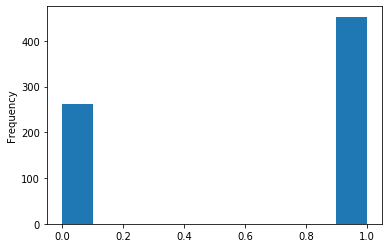

In [62]:
new_filt_tit_data = filtered_titanic_data.replace({'male': 1, 'female': 0})
print(new_filt_tit_data['Sex'].value_counts())
new_filt_tit_data['Sex'].plot(kind='hist')

<h2>Análise do gráfico de idade</h2>
<h12><hr></h12>
<h5>Pode-se inferir que grande parte dos tripulantes tinham entre 20 e 40 anos</h5>
<h5>Possuindo outrossim uma quantidade relativamente considerável de pessoas idosas, que podem não ser considerados outliers,</h5>
<h5>visto que não é incosistente nem apresenta um valor atípico relativo a série, pois existem muitos valores próximos na terceira idade, sendo o mais divergente o de ~80 anos</h5>

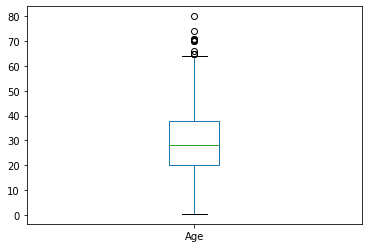

In [63]:
new_filt_tit_data['Age'].plot(kind='box')

<h4>Apresentando outra representação apenas para expor que não existem outliers</h4>
<h12><hr></h12>
<h5>Dada essa quantidade de dados concentradas entre 20 e 30 anos percebe-se que os dados não estão balanceados</h5>

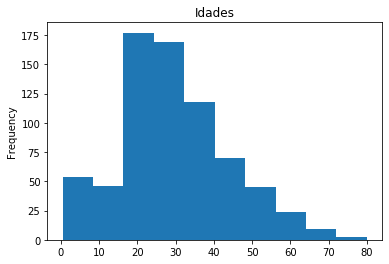

In [64]:
new_filt_tit_data['Age'].plot(kind='hist', title='Idades')

<h2>Análise do gráfico de preços</h2>
<h12><hr></h12>
<h5>A maior parte dos preços estão na faixa de 0 e 50, existindo claros outliers nessa coluna</h5>
<h5>Especialmente esse valor maior que 500 e alguns dos pontos mais afastadas da amostra mais contígua próxima da extremidade superior</h5>
<h5>Estes dados não estão balanceados</h5>

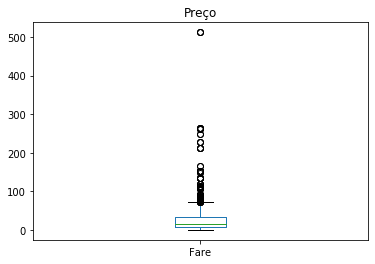

In [65]:
new_filt_tit_data['Fare'].plot(kind='box', title='Preço')

<h4>Dados relacionados a irmãos e cônjuges no navio, pessoas no mesmo nível na árvore genealógica</h4>
<h20><hr></h20>
<h5>Há uma uma grande quantidade grande de 0's e 1's, tendo valor bastante diminuido e variando até 5</h5>
<h5>Os dados não estão balanceados</h5>

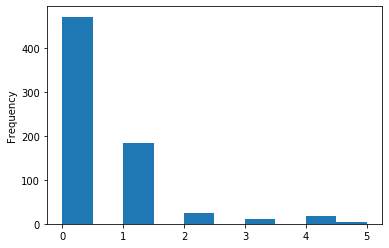

In [66]:
new_filt_tit_data['SibSp'].plot(kind='hist')

<h4>Dados relacionados a parentes e crianças no navio, pessoas de níveis divergentes na árvore genealógica</h4>
<h20><hr></h20>
<h5>Há uma uma grande quantidade grande de 0's e um quinto desses de 1's, tendo valor bastante diminuido e variando até 6, sendo este quase nulo</h5>
<h5>Os dados não estão balanceados</h5>

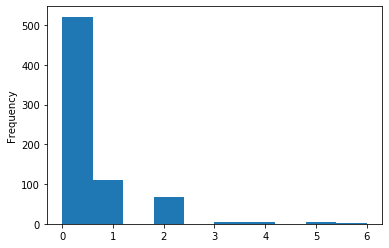

In [67]:
new_filt_tit_data['Parch'].plot(kind='hist')


<h2>Classe dos passageiros</h2>
<h15><hr></h15>
<h5>Observando esse histograma percebe-se que a maior parte das pessoas estão na terceira classe</h5>
<h5>Havendo uma quantidade deveras semelhante de pessoas na primeira e segunda classes</h5>
<h5>Dados não estão muito balanceados por causa da terceira classe</h5>

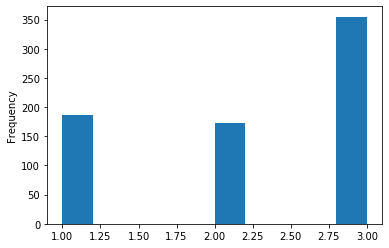

In [68]:
new_filt_tit_data['Pclass'].plot(kind='hist')

<h2>Matriz de correlação</h2>
<h4>Através da extração da matriz de correlação da base de dados, e observando a coluna survived que é a que se deseja prever, temos: </h4>
<h15><hr><h15>
    <ul style="list-style-type:circle;">
  <li><h5>Age: Possui uma correlação bastante baixa com idade, podendo inferir que uma influência muito baixa em pouca e idade e maior chance de sobrevivência</h5></li>
  <li><h5>Sex: Correlação negativa com o sexo, visto que mulher foi considerado 0 e survived é 1, quanto maior survived menor o sex, ou seja, mais mulheres sobreviveram</h5></li>
  <li><h5>SibSp e Parch: Praticamente não exercem influência, principalmente SibSp</h5></li>
  <li><h5>Fare: O preço possui uma correlação leve, mas considerável, quanto mais foi pago, mais sobreviveram</h5></li>
  <li><h5>PClass: Há uma correlação negativa, quanto menor a classe mais sobreviveram</h5></li>
</ul>

In [69]:
features_corr = ['Age', 'Sex', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Survived']
df = pd.DataFrame(new_filt_tit_data[features_corr])
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,Sex,SibSp,Parch,Fare,Pclass,Survived
Age,1,0.0932536,-0.308247,-0.189119,0.0960667,-0.369226,-0.0772211
Sex,0.0932536,1,-0.10395,-0.246972,-0.184994,0.15546,-0.538826
SibSp,-0.308247,-0.10395,1,0.38382,0.138329,0.0672474,-0.0173584
Parch,-0.189119,-0.246972,0.38382,1,0.205119,0.0256831,0.093317
Fare,0.0960667,-0.184994,0.138329,0.205119,1,-0.554182,0.268189
Pclass,-0.369226,0.15546,0.0672474,0.0256831,-0.554182,1,-0.359653
Survived,-0.0772211,-0.538826,-0.0173584,0.093317,0.268189,-0.359653,1


<h2>Selecionando os dados para a previsão e o target do problema</h2>
<h15><hr></h15>
<h5>Foi aplicado também uma normalização dos dados, especialmente para tratar os outliers relativos à idade</h5>
<h5>Quase todos os atributos foram selecionados exceto o ticket, quarto e aonde o tripulante embarcou</h5>
<h5>Nessa etapa houve também uma normalização dos dados</h5>

In [85]:
features = ['Age', 'Sex', 'SibSp', 'Parch','Pclass', 'Fare']

bf_X = np.array(new_filt_tit_data[features])
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(bf_X)

y = new_filt_tit_data.Survived

<h1>XGBoost</h1>
<h15><hr></h15>
<h4>- Algoritmo baseado em árvore. Em problemas envolvendo bases não estruturadas como imagens, algoritmos envolvendo redes neurais artificiais são considerados melhores</h4>
<h4>- Mas, no caso desse problema de pequeno porte com dados em tabelas algoritmos baseados em árvore de decisão são considerados melhores</h4>
<h4>- Modelo é feito sequencialmente enquanto diminui o erro do modelo anterior enquanto aumenta a influência dos melhores modelos</h4>
<h4>- Utiliza o algoritmo do gradiente (que minimiza o erro em modelos sequenciais) com processamento paralelo, 
<h4>e vai podando as arvóres de decisão que não são muito eficientes na classificação de instâncias, o que reduzirá a complexidade do classificador, assim melhorando a acurácia preditiva evitando overfitting </h4>

In [86]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=12, test_size=0.20)
titanic_model_XGB = XGBClassifier(random_state=12)
titanic_model_XGB.fit(train_X, train_y)
titanic_predictions_XGB = titanic_model_XGB.predict(val_X)
accuracy = accuracy_score(val_y, titanic_predictions_XGB)

conf = confusion_matrix(val_y, titanic_predictions_XGB)                       
name = 'XGBoost'

<h2>Análise dos resultados</h2>
<h15><hr></h15>
<h4>- Dada esta matriz de correlação podemos inferir os outros dados, temos que Matriz[0][0] = Verdadeiros negativos, Matriz[0][1] = Falso positivo</h4>
<h4>  Matriz[1][1] = Verdadeiro positivo, matriz[1][0] = falso negativo</h4>
<h4>- A acurácia é dada por: (Vp+Vn)/(Vp+Vn+Fp+Fn), mede a proximidade da medida para um determinado valor</h4>
<h4>- A precisão mede a próximidade da medida entre os dados, e é dada por: (Vp)/(Vp+Fn)</h4>
<h4>- O parâmetro f1 é dado por: 2*((Precision)*(sensitividade)/(VN + FN)), 
<h4>- f1 é bom quando se deseja achar uma balança entre precisão e sensitividade e há uma distribuição muito desigual entre as classes</h4>



In [87]:
print("Acurácia do método XGBoost: %.3f%%" % (((conf[1][1]+conf[0][0])/(conf[1][1]+conf[0][0]+conf[0][1]+conf[1][0]))*100))
print("Precisão F1 por XGBoost: %.3f%% " % (2*(((conf[1][1])/(conf[1][1]+conf[0][1]))*((conf[1][1])/(conf[1][1]+conf[1][0])))/(((conf[1][1])/(conf[1][1]+conf[0][1]))+((conf[1][1])/(conf[1][1]+conf[1][0])))*100))
print(Sensitivity_specificity(conf, name))
print("Matriz de confusão:\n{}".format(conf))

Acurácia do método XGBoost: 82.517%
Precisão F1 por XGBoost: 75.728% 
Sensitividade do modelo XGBoost: 0.684
Especificidade do modelo XGBoost: 0.919

Matriz de confusão:
[[79  7]
 [18 39]]


<h1>Random Forest</h1>
<h15><hr></h15>
<h4>- Também é um algoritmo baseado em árvore, tendo sua potencialidade bem desenvolvida nesse tipo de problema</h4>
<h4>- Utiliza um meta-algoritmo de bagging, que reduz a variância e overfitting, com métodos de aproximação da média</h4>
<h4>- Um subset das features é aleatoriamente escolhido para a construção da floresta, uma gama de árvores de decisão</h4>

In [88]:
titanic_model_rf = RandomForestClassifier(n_jobs=2, random_state=5, n_estimators=10)
titanic_model_rf.fit(train_X, train_y)
titanic_predictions_rf = titanic_model_rf.predict(val_X)
accuracy_rf = accuracy_score(val_y, titanic_predictions_rf)
f1_accuracy_rf = f1_score(val_y, titanic_predictions_rf, average='macro')

conf = confusion_matrix(val_y, titanic_predictions_rf)
name = 'Random Forest'

print("Acurácia do método Random forest classifier: %.3f%%" %(((conf[1][1]+conf[0][0])/(conf[1][1]+conf[0][0]+conf[0][1]+conf[1][0]))*100))
print("Precisão F1 por Random Forest: %.3f%% " % (2*(((conf[1][1])/(conf[1][1]+conf[0][1]))*((conf[1][1])/(conf[1][1]+conf[1][0])))/(((conf[1][1])/(conf[1][1]+conf[0][1]))+((conf[1][1])/(conf[1][1]+conf[1][0])))*100))
print(Sensitivity_specificity(conf, name))
print("Matriz de confusão:\n{}".format(confusion_matrix(val_y, titanic_predictions_rf)))

Acurácia do método Random forest classifier: 79.021%
Precisão F1 por Random Forest: 72.222% 
Sensitividade do modelo Random Forest: 0.684
Especificidade do modelo Random Forest: 0.860

Matriz de confusão:
[[74 12]
 [18 39]]


<h2><strong>BÔNUS</strong></h2>

<h2>Alteração do Booster do KGBoost<h2>
<h25><hr></h25>
<h4>- Foi alterado o parâmetro do booster que representa como as bases do classificador serão feitas. Foi alterado de uma árvore para um algoritmo linear, tendo resultados bem piores</h4>
<h4>- Visto que, como apontado anteriormente esses problemas com tamanho pequeno/médio e com tabelas é uma das formas que algoritmos baseados em árvore são melhores</h4>

In [89]:
Bonus_titanic_model_XGB = XGBClassifier(random_state=1, booster='gblinear', feature_selector='shuffle')
Bonus_titanic_model_XGB.fit(train_X, train_y)
Bonus_titanic_predictions_XGB = Bonus_titanic_model_XGB.predict(val_X)
Bonus_accuracy_rf = accuracy_score(val_y, Bonus_titanic_predictions_XGB)
print("Acurácia método XGBoost alterando o booster de arvore para linear, e a ordem de seleção das features: %.3f%%" % (Bonus_accuracy_rf * 100.0))

Acurácia método XGBoost alterando o booster de arvore para linear, e a ordem de seleção das features: 60.140%


<h2>Alteração da profundidade e número de estimadores do RandomForest<h2>
<h25><hr></h25>
<h4>Foram alterados os parâmetros de profundidade máxima e o  n_estimadores (que está relacionado ao número máximo de árvores na floresta).</h4>
<h4>O método random forest funciona criando múltiplas árvores de decisão, esse valor foi alterado de 10 para 100 e foi obtida uma melhora de quase 3% em comparação com o teste anterior</h4>

In [90]:
#--------Bônus--------



Bonus_titanic_model_rf = RandomForestClassifier(n_jobs=2, random_state=4, n_estimators=100)
Bonus_titanic_model_rf.fit(train_X, train_y)
Bonus_titanic_predictions_rf = Bonus_titanic_model_rf.predict(val_X)
Bonus_accuracy_rf = accuracy_score(val_y, Bonus_titanic_predictions_rf)

print("Acurácia do método Random forest classifier após alterar a profundidade máxima e número de estimadores: %.3f%%" %(Bonus_accuracy_rf*100.0))

Acurácia do método Random forest classifier após alterar a profundidade máxima e número de estimadores: 81.818%
